**Import Libraries**

In [ ]:
# the tuning output  -> is the solution
# Genetic algorithms -> pygad
# ahmed gad

# tfdf and pipeline


In [ ]:
!pip install -r requirements.txt

In [ ]:
## Major
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import re
import string
from tqdm import tqdm
import joblib

## plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## nltk -- for text processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

## sklearn -- for processing and models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## SMOTE for imblanced dataset
from imblearn.over_sampling import SMOTE

## Optimization Algorithm using Jaya Optimizer
from mealpy.swarm_based.JA import BaseJA, OriginalJA, LevyJA

## Filter Warnings
import warnings
warnings.filterwarnings('ignore')

**Load the dataset**

In [ ]:
df = pd.read_csv("twitter-sanders-apple2.csv",
                 encoding='ISO-8859-1')
df.head()

,class,text
0,1,swype iphone crack Iphone
1,1,adding carrier support iPhone announced
2,1,Hilarious video duet Siri Pretty much sums love affair
3,1,made easy switch iPhone
4,1,realized reason twitter thanks


In [ ]:
print('The Shape of the Dataset is: ', df.shape)

The Shape of the Dataset is:  (475, 2)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   475 non-null    int64 
 1   text    475 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.5+ KB


In [ ]:
df.dtypes

,0
class,int64
text,object


In [ ]:
df.isnull().sum(axis=0)

,0
class,0
text,0


In [ ]:
df['class'].unique()

array([1, 0])

In [ ]:
df[df['class']=='class']

,class,text


In [ ]:
df[df['class']!='class']

,class,text
0,1,swype iphone crack Iphone
1,1,adding carrier support iPhone announced
2,1,Hilarious video duet Siri Pretty much sums love affair
3,1,made easy switch iPhone
4,1,realized reason twitter thanks
...,...,...
470,0,Houston problem iPad restoring hours installing right
471,0,Siri went little last night Come shit together launch
472,0,teamed instead make SYNC system focus sweet SYNC EpicFail
473,0,Really done iTunes click Music Movies Shows playlists


In [ ]:
df['class'].value_counts()

,count
class,
0,315
1,160


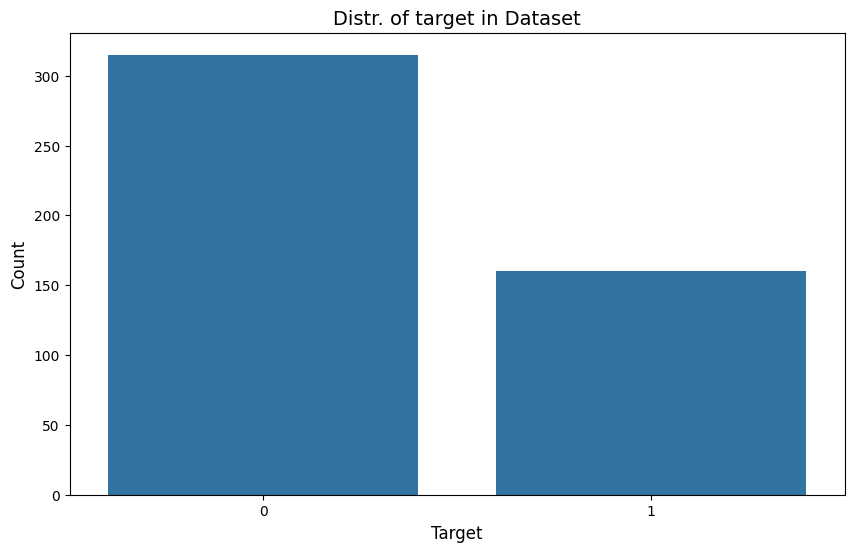

In [ ]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [ ]:
for i in range(len(df['class'])):
  if df['class'][i] == 'Pos':
    df['class'][i] = 1
  else:
    df['class'][i] = 0


print(df['class'].unique())

[0]


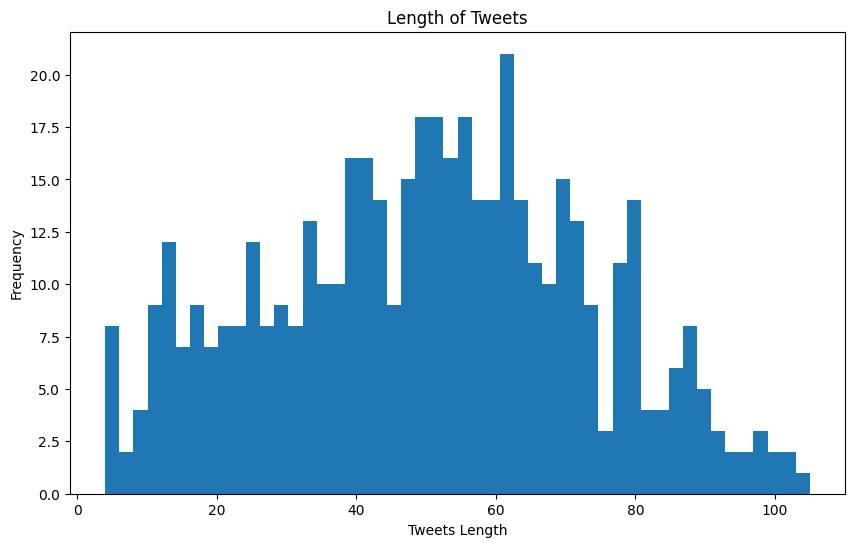

In [ ]:
## Check Length of Tweets
length_tweets = df['text'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
## Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

## Extracting hashtags from non racist tweets
hash_neg = hashtag_extract(df['text'][df['class'] == 0])  ## Negative
hash_pos = hashtag_extract(df['text'][df['class'] == 1])  ## Positive


## Unnesting list
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])

print(hash_pos)

[]


In [ ]:
## Hashtags in Tweets
a_neg = nltk.FreqDist(hash_neg)
a_pos = nltk.FreqDist(hash_pos)

print(a_pos)

<FreqDist with 0 samples and 0 outcomes>


Text(0.5, 80.7222222222222, '')

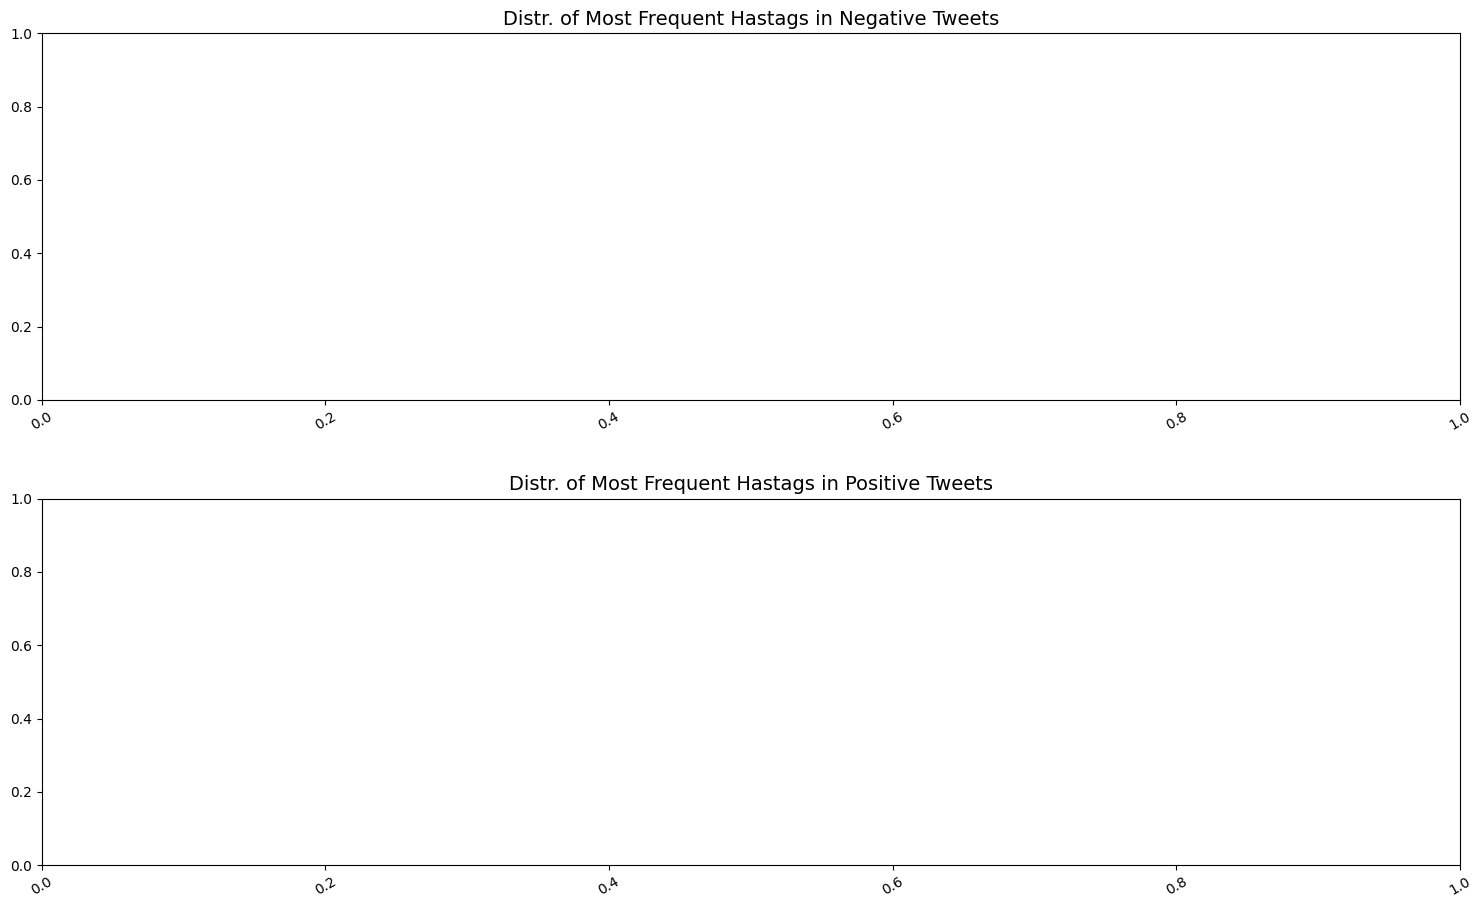

In [ ]:

## Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                  'Count': list(a_neg.values())})

## Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                  'Count': list(a_pos.values())})

# selecting top 15 most frequent hashtags
df_neg = df_neg.nlargest(columns='Count', n=15)
df_pos = df_pos.nlargest(columns='Count', n=15)

## Plotting
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')

In [ ]:
## Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''

    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

In [ ]:
## Removing @user in tweets, and apply the function
df['text'] = df['text'].apply(remove_pattern, pattern=r'@[\w]*')
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
## An exmaple before removing links
df['text'].iloc[400]

'Smashed another iPhone screen gonna make phone durable Tired fixing'

In [ ]:
## Define a regular expression pattern to match URLs
## Apply the above function
df['text'] = df['text'].apply(remove_pattern, pattern=r'https?://\S+|www\.\S+')
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
## An exmaple before removing repeated chars
df['text'].iloc[0]

'swype iphone crack Iphone'

In [ ]:
## A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    ## Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    ## Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)

    return cleaned_string

## Apply the above function
df['text'] = df['text'].apply(remove_excessive_repeated_characters)
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
## The same exmaple after removing repeated chars
df['text'].iloc[0]

'swype iphone crack Iphone'

In [ ]:
## Check on sample before mapping emoticons
df['text'].iloc[73]

'lovin iPhone update especially slide screen good'

In [ ]:
## Convert Emojis to Text : example 😀 to Happy , 😢 Sad
## This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
## So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


## Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

## Apply the function on our dataset
df['text'] = df['text'].apply(convert_emoticons)
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
## The same exmaple after mapping emoticons
df['text'].iloc[73]

'lovin iPhone update especially slide screen good'

In [ ]:
## Removing Punctuations, Numbers, and Special Characters
df['text'] = df['text'].str.replace('[^a-zA-Z#]', ' ')
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
df['text'].iloc[73]

'lovin iPhone update especially slide screen good'

In [ ]:
## Removing Short Words
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
df['text'].iloc[123]

'nice store replaced phone gratis showed hairline crack screen thanks'

In [ ]:
## Call the above function (remove_pattern), We want to remove the numbers from words
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
df['text'] = np.vectorize(remove_pattern)(input_txt=df['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
df['text'] = df['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/-]')
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
## An exmaple before removing special chars
df['text'].iloc[2]

'Hilarious video duet Siri Pretty much sums love affair'

In [ ]:
## Define a regular expression pattern to match special characters
## Apply the function to the dataset
df['text'] = df['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/-]')
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
## The same exmaple after removing special chars
df['text'].iloc[2]

'Hilarious video duet Siri Pretty much sums love affair'

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
## An exmaple before solving that
df['text'].iloc[3]

'made easy switch iPhone'

In [ ]:
## A Function to remove redundant words like (I've, You'll)
## Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    ## Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    ## Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    ## Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    ## Remove extra spaces
    clean_text = ' '.join(clean_text.split())

    return clean_text


## Apply the above function
df['text'] = df['text'].apply(remove_redundant_words_extra_spaces)

In [ ]:
## The same exmaple after solving that
df['text'].iloc[3]

'made easy switch iPhone'

In [ ]:
## Call the above function (remove_pattern), We want to remove the numbers from words
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
df['text'] = np.vectorize(remove_pattern)(input_txt=df['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
df.head()


,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
df['text'].iloc[123]

'nice store replaced phone gratis showed hairline crack screen thanks'

In [ ]:
## Removing Short Words
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,class,text
0,0,swype iphone crack Iphone
1,0,adding carrier support iPhone announced
2,0,Hilarious video duet Siri Pretty much sums love affair
3,0,made easy switch iPhone
4,0,realized reason twitter thanks


In [ ]:
df['text'].iloc[123]

'nice store replaced phone gratis showed hairline crack screen thanks'

In [ ]:
df = df[df['text'] != '']

In [ ]:
## Download the dataset here at this step before Stemming or Lemmatizing
df.to_excel('twitter-sanders-apple2-after-data-preparation.xlsx', index=False)

In [ ]:
## Download the dataset here at this step before Stemming or Lemmatizing
df.to_csv('twitter-sanders-apple2-after-data-preparation.csv', index=False)

In [ ]:
df['text'].iloc[29]

'question iPhone'

# Transformer

## Apply Pipeline of HuggingFace on Twitter database 2

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Check the task name and the defualt model
classifier.task, classifier.model

('sentiment-analysis',
 DistilBertForSequenceClassification(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
           

In [ ]:
# List of examples
results = classifier(["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.5309


In [ ]:
# Define a function t0 analyze sentiment
def analyze_sentiment(text):
    result = classifier(text)[0]
    return result['label']
    # convert the label to postive/negative
    if label == 'POSITIVE':
        return 1
    else:
        return 0

In [ ]:
# Apply the sentiment analysis to each tweet
df['sentiment'] = df['text'].apply(analyze_sentiment)

In [ ]:
# Save the result of the transformer pipeline
df.to_csv('twitter-sanders-apple2_pipeline.csv', index=False)

## Apply AutoModel & AutoTokenizer of HuggingFace on Twitter database 2

In [ ]:
# Load the model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
# Define a function to analyze sentiment
def analyze_sentiment_AT(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**inputs)
    logits = outputs.logits
    predicted = logits.argmax().item()
    return 'POSITIVE' if predicted == 1 else 'NEGATIVE'

In [ ]:
# Apply the sentiment analysis to each tweet
df['sentiment'] = df['text'].apply(analyze_sentiment_AT)

In [ ]:
# Save the results to a new CSV file
df.to_csv('twitter_sanders-apple2_AutoTokenizer.csv', index=False)